# MATH50003 Numerical Analysis (2022–23)
# Lab 6: Least squares, QR and Cholesky
This lab explores the the least squares problem for fitting functions with polynomials,
computing the QR factorisation with both reflections and rotations,
and implementing a tridiagonal Cholesky decomposition (which we shall see later arises in the 1D Poisson equation).

In [15]:
using Plots, Test, LinearAlgebra

------

When $m = n$ a least squares fit by a polynomial becomes _interpolation_:
the approximating polynomial will fit the data exactly. That is, for
$$
p(x) = ∑_{k = 0}^{n-1} p_k x^k
$$
and $x_1, …, x_n ∈ ℝ$, we choose $p_k$ so that $p(x_j) = f(x_j)$ for
$j = 1, …, n$.

**Problem 1.1** Complete the following function which returns a rectangular _Vandermonde matrix_:
a matrix $V ∈ ℝ^{m × n}$ such that
$$
V * \begin{bmatrix} p_0\\ ⋮ \\p_n \end{bmatrix} = \begin{bmatrix} p(x_1)\\ ⋮ \\p(x_m) \end{bmatrix}
$$

In [16]:
function vandermonde(𝐱, n) # 𝐱 = [x_1,…,x_m]
    m = length(𝐱)
    [𝐱[j]^k for j = 1:m, k = 0:n-1]

end

n = 1000
𝐱 = range(0, 0.5; length=n)
V = vandermonde(𝐱, n) # square Vandermonde matrix
# if all coefficients are 1 then p(x) = (1-x^n)/(1-x)
@test V * ones(n) ≈ (1 .- 𝐱 .^ n) ./ (1 .- 𝐱)

Test Passed

Inverting the square Vandermonde matrix is a way of computing coefficients from function
samples. That is, solving
$$
V𝐜 = \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_n) \end{bmatrix}
$$
Gives the coefficients of a polynomial $p(x)$ so that $p(x_j) = f(x_j)$.
Whether an interpolation is actually close to a function is a subtle question,
involving properties of the function, distribution of the sample points $x_1,…,x_n$,
and round-off error.
A classic example is:
$$
  f_M(x) = {1 \over M x^2 + 1}
$$
where the choice of $M$ can dictate whether interpolation at evenly spaced points converges.

**Problem 1.2** Interpolate $1/(4x^2+1)$ and $1/(25x^2 + 1)$ at an evenly spaced grid of $n$
points, plotting the solution at a grid of $1000$ points. For $n = 50$ does your interpolation match
the true function?  Does increasing $n$ to 400 improve the accuracy? How about using `BigFloat`?

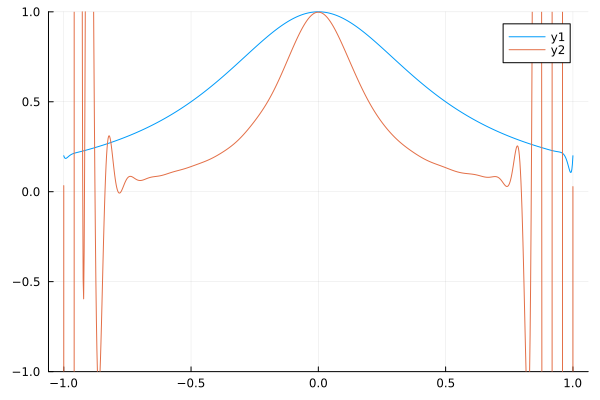

In [17]:
n = 50
𝐱 = range(-1, 1; length=n)
𝐠 = range(-1, 1; length=1000) # plotting grid

V = vandermonde(𝐱, n)
V_g = vandermonde(𝐠, n)
f_4 = x -> 1/(4x^2 +1)
c_4 = V \ f_4.(𝐱)
f_25 = x -> 1/(25x^2 +1)
c_25 = V \f_25.(𝐱)
plot(𝐠, V_g*c_4; ylims=(-1,1))
plot!(𝐠, V_g*c_25)

# TODO: interpolate 1/(10x^2 + 1) and 1/(25x^2 + 1) at $𝐱$, plotting both solutions evaluated at
# the grid 𝐠. Hint: use a rectangular Vandermonde matrix to evaluate your polynomial on 𝐠. Remember
# `plot(𝐱, 𝐟)` will create a new plot whilst `plot!(𝐱, 𝐟)` will add to an existing plot.

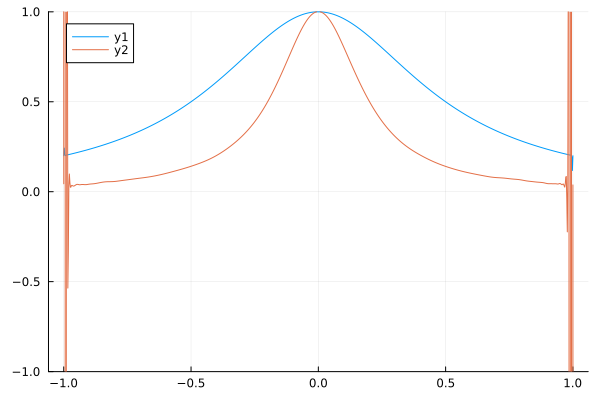

In [18]:
# TODO: repeat the experiment with `n = 400` and observe what has changed.
n = 400
𝐱 = range(-1, 1; length=n)
𝐠 = range(-1, 1; length=1000) # plotting grid

V = vandermonde(𝐱, n)
V_g = vandermonde(𝐠, n)
f_4 = x -> 1/(4x^2 +1)
c_4 = V \ f_4.(𝐱)
f_25 = x -> 1/(25x^2 +1)
c_25 = V \f_25.(𝐱)
plot(𝐠, V_g*c_4; ylims=(-1,1))
plot!(𝐠, V_g*c_25)

**Problem 1.3** Repeat the previous problem but now using _least squares_: instead of interpolating,
use least squares on a large grid: choose the coefficients of a degree $(n-1)$ polynomial so that
$$
    \left\| \begin{bmatrix} p(x_1) \\ ⋮ \\ p(x_m) \end{bmatrix} - \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_m) \end{bmatrix} \right \|.
$$
is minimised.
Does this improve the convergence properties? Do you think convergence for a least squares approximation
is dictated by the radius of convergence of the corresponding Taylor series?
Hint: use the rectangular Vandermonde matrix to setup the Least squares system.

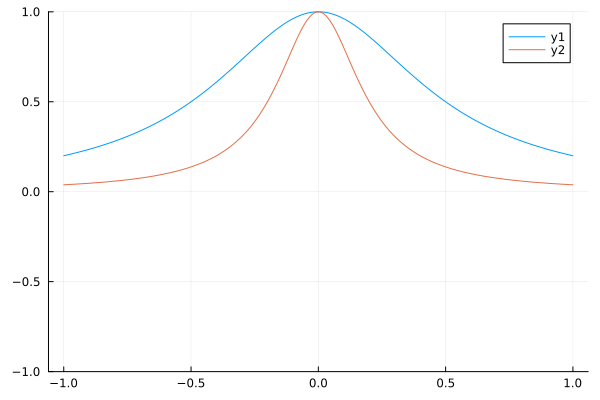

In [19]:
n = 50 # use basis [1,x,…,x^(49)]
𝐱 = range(-1, 1; length=500) # least squares grid
𝐠 = range(-1, 1; length=2000) # plotting grid

# TODO: interpolate 1/(10x^2 + 1) and 1/(25x^2 + 1) at $𝐱$, plotting both solutions evaluated at
# the grid 𝐠. Hint: use a rectangular Vandermonde matrix to evaluate your polynomial on 𝐠. Remember
# `plot(𝐱, 𝐟)` will create a new plot whilst `plot!(𝐱, 𝐟)` will add to an existing plot.

V = vandermonde(𝐱, n)
V_g = vandermonde(𝐠, n)
f_4 = x -> 1/(4x^2 + 1)
𝐜_4 = V \ f_4.(𝐱)
f_25 = x -> 1/(25x^2 + 1)
𝐜_25 = V \ f_25.(𝐱)

plot(𝐠, V_g*𝐜_4; ylims=(-1,1))
plot!(𝐠, V_g*𝐜_25)

-------

In lectures we did a quick-and-dirty implementation of Householder QR.
One major issue though: it used $O(m^2 n^2)$ operations, which is too many!
By being more careful about how we apply and store reflections we can avoid this,
in particular, taking advantage of the types `Reflection` and `Reflections` we developed
last lab.

**Problem 2** Complete the following function that implements
Householder QR for a real matrix $A ∈ ℝ^{m × n}$ where $m ≥ n$ using only $O(mn^2)$ operations, using
 `Reflection` and `Reflections` from PS5.
Hint: We have added the overload functions `*(::Reflection, ::AbstractMatrix)` and
`*(::Reflections, ::AbstractMatrix)` so that they can be multiplied by an $m × n$ matrix in $O(mn)$ operations.

In [25]:
import Base: *, size, getindex

struct Reflection{T} <: AbstractMatrix{T}
    v::Vector{T}
end

struct Reflections{T} <: AbstractMatrix{T}
    V::Matrix{T}
end

## TODO: copy over implementation of Reflection and Reflections from PS5.
Reflection(x::Vector{T}) where T = Reflection{T}(x/norm(x))

function size(Q::Reflection)
    (length(Q.v),length(Q.v))
end

# getindex(Q, k, j) is synonym for Q[k,j]
function getindex(Q::Reflection, k::Int, j::Int)

    i = -2*(Q.v[k] * conj(Q.v[j]))
    if k == j
        i += 1
    end
    # TODO: implement Q[k,j] == (I - 2v*v')[k,j] but using O(1) operations.
    # Hint: the function `conj` gives the complex-conjugate
    i
end
function *(Q::Reflection, x::AbstractVector)
    # TODO: implement Q*x, equivalent to (I - 2v*v')*x but using only O(n) operations
    x - 2*Q.v * dot(Q.v,x)
end

function householderreflection(s:: Bool, x::AbstractVector)
    y = copy(x)
    if s
        y[1] += norm(x) 
    else # note sign(z) = exp(im*angle(z)) where `angle` is the argument of a complex number
        y[1] += sign(x[1])*norm(x) 
    end
    w = y/norm(y)
    Reflection(w)
end

size(Q::Reflections) = (size(Q.V,1), size(Q.V,1))

function *(Q::Reflections, x::AbstractVector)
    # TODO: Apply Q in O(mn) operations by applying
    # the reflection corresponding to each column of Q.V to x
    m, n = size(Q.V)
    for j in n:-1:1
        x = Reflection(Q.V[:, j])*x
    end
    x
end

function getindex(Q::Reflections, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(mn) operations (hint: use *)
    T = eltype(Q.V)
    m,n = size(Q.V)
    ej = zeros(T, m)
    ej[j] = one(T)

    return (Q * ej)[k]

end





## Implementations of Reflection * AbstractMatrix
function *(Q::Reflection, X::AbstractMatrix)
    T = promote_type(eltype(Q), eltype(X))
    m,n = size(X)
    ret = zeros(T, m, n)
    for j = 1:n
        ret[:,j] = Q * X[:,j]
    end
    ret
end

## Implementations of Reflections * AbstractMatrix
function *(Q::Reflections, X::AbstractMatrix)
    T = promote_type(eltype(Q), eltype(X))
    m,n = size(X)
    ret = zeros(T, m, n)
    for j = 1:n
        ret[:,j] = Q * X[:,j]
    end
    ret
end



function householderqr(A)
    T = eltype(A)
    m,n = size(A)
    if n > m
        error("More columns than rows is not supported")
    end

    R = zeros(T, m, n)
    Q = Reflections(zeros(T, m, n))
    Aⱼ = copy(A)

    for j = 1:n
        # TODO: rewrite householder QR to use Reflection and
        𝐚₁ = Aⱼ[:,1] # first columns of Aⱼ
        Q₁ = householderreflection(𝐚₁[1] < 0,𝐚₁)
        Q₁Aⱼ = Q₁*Aⱼ
        α,𝐰 = Q₁Aⱼ[1,1],Q₁Aⱼ[1,2:end]
        Aⱼ₊₁ = Q₁Aⱼ[2:end,2:end]

        # populate returned data
        R[j,j] = α
        R[j,j+1:end] = 𝐰

        # following is equivalent to Q = Q*[I 0 ; 0 Qⱼ]
        Q.V[j:end, j] = Q₁.v

        Aⱼ = Aⱼ₊₁ # this is the "induction"

    end
    Q,R
end

A = randn(600,400)
Q,R = householderqr(A)
@test Q*R ≈ A

Test Passed

--------

We now consider a Cholesky factorisation for tridiagonal matrices. Since we are assuming the
matrix is symmetric, we will use a special type `SymTridiagonal` that captures the symmetry.
In particular, `SymTridiagonal(dv, eu) == Tridiagonal(ev, dv, ev)`.

**Problem 3** Complete the following
implementation of `mycholesky` to return a `Bidiagonal` cholesky factor in $O(n)$ operations.

In [43]:
# return a Bidiagonal L such that L'L == A (up to machine precision)
# You are allowed to change A
function mycholesky(A::SymTridiagonal)
    d = A.dv # diagonal entries of A
    u = A.ev # sub/super-diagonal entries of A
    T = float(eltype(A)) # return type, make float in case A has Ints
    n = length(d)
    ld = zeros(T, n) # diagonal entries of L
    ll = zeros(T, n-1) # sub-diagonal entries of L
    ## TODO: populate the diagonal entries ld and the sub-diagonal entries ll
    # of L so that L*L' ≈ A
    ld[1] = sqrt(d[1])
    for j in 1:n-1
        ll[j] = u[j] / ld[j]
        ld[j+1] = sqrt(d[j] - (ll[j])^2)
    end
    Bidiagonal(ld, ll, :L)
end

n = 1000
A = SymTridiagonal(2*ones(n),-ones(n-1))
L = mycholesky(A)
@test L*L' ≈ A

Test Passed

------

## Advanced

This last problem is advanced so may be considered optional.

An alternative to using reflections to introduce zeros is to use rotations.
This is particularly convenient for tridiagonal matrices, where one needs to only
make one sub-diagonal zero. Here we explore a tridiagonal QR built from rotations
in a way that the factorisation can be computed in $O(n)$ operations.

**Problem 4.1** Complete the implementation of `Rotations`, which represents an orthogonal matrix `Q` that is a product
of rotations of angle `θ[k]`, each acting on the entries `k:k+1`. That is, it returns $Q = Q_1⋯Q_k$ such that
$$
Q_k[k:k+1,k:k+1] =
\begin{bmatrix}
\cos θ[k] & -\sin θ[k]\\
\sin θ[k] & \cos θ[k]
\end{bmatrix}
$$

In [22]:
struct Rotations{T} <: AbstractMatrix{T}
    θ::Vector{T} # a vector of angles
end

import Base: *, size, getindex

# we use the number of rotations to deduce the dimensions of the matrix
size(Q::Rotations) = (length(Q.θ)+1, length(Q.θ)+1)

function *(Q::Rotations, x::AbstractVector)
    T = promote_type(eltype(Q), eltype(x))
    y = Vector{T}(x) # copies x to a new Vector whose eltype is T
    # TODO: Apply Q in O(n) operations, modifying y in-place



    y
end

function getindex(Q::Rotations, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(n) operations (hint: use *)


end

θ1 = randn(5)
Q = Rotations(θ1)
@test_broken Q'Q ≈ I
@test_broken Rotations([π/2, -π/2]) ≈ [0 0 -1; 1 0 0; 0 -1 0]

Test Broken
  Expression: Rotations([π / 2, -π / 2]) ≈ [0 0 -1; 1 0 0; 0 -1 0]

When one computes a tridiagonal QR, we introduce entries in the
second super-diagonal. Thus we will use the `UpperTridiagonal` type
from Lab 4:

In [23]:
import Base: *, size, getindex, setindex!
struct UpperTridiagonal{T} <: AbstractMatrix{T}
    d::Vector{T}   # diagonal entries
    du::Vector{T}  # super-diagonal enries
    du2::Vector{T} # second-super-diagonal entries
end

size(U::UpperTridiagonal) = (length(U.d),length(U.d))

function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j - k == 0
        d[j]
    elseif j - k == 1
        du[k]
    elseif j - k == 2
        du2[k]
    else
        0
    end
end

function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j > k+2
        error("Cannot modify off-band")
    end
    if j - k == 0
        d[k] = v
    elseif j - k == 1
        du[k] = v
    elseif j - k == 2
        du2[k] = v
    else
        error("Cannot modify off-band")
    end
    U # by convention we return the matrix
end

setindex! (generic function with 122 methods)

**Problem 4.2** Combine `Rotations` and `UpperTridiagonal` from last problem sheet
to implement a banded QR decomposition, `bandedqr`, that only takes $O(n)$ operations. Hint: the
`atan(y,x)` function gives the angle of a vector `[x,y]`.

In [24]:
function bandedqr(A::Tridiagonal)
    n = size(A, 1)
    Q = Rotations(zeros(n - 1)) # Assume Float64
    R = UpperTridiagonal(zeros(n), zeros(n - 1), zeros(n - 2))

    # TODO: Populate Q and R by looping through the columns of A.


    Q, R
end

A = Tridiagonal([1, 2, 3, 4], [1, 2, 3, 4, 5], [1, 2, 3, 4])
Q, R = bandedqr(A)
@test_broken Q*R ≈ A

Test Broken
  Expression: Q * R ≈ A

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*